In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import uuid #for generating guid code 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
import random

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
batch_size = 32
epochs = 60
random_state = 21

threshold = 7000 #intensity of pixel to ignore

#number of depth images to keep, only a certain number contains the base gangli
zmin = 20
zmax = 30

#portion of image which contains the interested part of brain scan
xmin = 33
xmax = 162
ymin = 73
ymax = 202

deltaX = xmax-xmin
deltaY = ymax-ymin
deltaZ = zmax-zmin

irangemin = zmin
irangemax = zmax

img_size = deltaX+1

#during data augmentation the images will be shifted in the 4 directions of 5% and 10% of the width
shifting_percentages = [img_size*0.05, img_size*0.1, -img_size*0.05, -img_size*0.1]

background_percentage = 0.4

num_classes = 2

#model hyperparameters
conv_depth_1 = 15
conv_depth_2 = 25 
conv_depth_3 = 50 
conv_depth_4 = 50
fc_nodes = 512

drop_prob_1 = 0.25
drop_prob_2 = 0.5
drop_prob_3 = 0.25 
drop_prob_4 = 0.5
l2_penalty = 1e-3

In [3]:
project_dir = os.getcwd()


try_num = 8
try_dir = os.path.join(project_dir, 'try_{try_num}'.format(try_num=try_num))
if os.path.exists(try_dir):
    raise Exception("Directory name already used, update try_num")
else:
    os.mkdir(try_dir)

In [4]:
data_folder = os.path.join(project_dir, 'CDOPA_dataset')
csv_path = os.path.join(project_dir, 'carbidopa.csv')

model_filepath = os.path.join(try_dir, 'model.h5')
summary_filepath = os.path.join(try_dir, 'model_summary.txt')
hist_csv_filepath = os.path.join(try_dir, 'history.csv')

In [5]:
"""
DATA LOADING FUNCTIONS
"""

def load_scan(path):
    slices = [pydicom.read_file(os.path.join(path, s), force=True) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def get_pixels(slices, rescale=False):
    if rescale:
        image = np.stack([s.pixel_array*(s.RescaleSlope*10) for s in slices])
        return np.array(image,dtype=np.float32)
    else:
        image = np.stack([s.pixel_array for s in slices])
        return np.array(image,dtype=np.int16)
    

def slicecutoff(slice, threshold):
    slice[slice<threshold]=0.
    return slice

    
def create_dataset(data_folder, rescale=False, threshold=threshold):

    patients = os.listdir(data_folder) #list all the folders containing the .dcm for each patient
    patients.sort()
    inumpatients = len(patients) #number of datapoints
    X_DATA = np.empty([inumpatients, img_size, img_size, deltaZ]) #initially 'empty dataset' to be filled
    
    for num_patient, patient in enumerate(patients):
        patient_n = get_pixels(load_scan(os.path.join(data_folder, patient)))

        #reference central slice and mask
        slice_central = patient_n[zmin+4]
        slice_centralcut = slice_central[xmin:xmax+1, ymin:ymax+1]

        if rescale:
            threshold_roi = slice_centralcut.max()*background_percentage
            threshold = threshold_roi

        mask_central = slicecutoff(slice_centralcut, threshold)

        for index, slice in enumerate(patient_n):
            #only central slices are considered for the dataset
            if index in range(zmin,zmax): 
                
                slicecut = slice[xmin:xmax+1, ymin:ymax+1]
                mask = slicecutoff(slicecut, threshold)

                #here it makes sure the larger portion of the mask is considered background
                #zeroing out the parts outsite the central region of interest
                if index < zmin + 4:
                    if (mask_central-mask).sum() > mask_central.sum():
                        slicecut[True] = 0.
                        mask[True] = 0.
                if index > zmin +4:
                    if abs((mask-mask_central)).sum() > mask_central.sum():
                        slicecut[True] = 0.
                        mask[True] = 0.
                
                X_DATA[num_patient,:,:,index-zmin] = slicecut
    
    return X_DATA
            

In [6]:
"""
DATASET MANIPULATION FUNCTIONS
"""

#shift param is how many pixel the image has to be shifted, 
# it has to be a signed flot for tanslation to the left or right


def shift_tensor(image, shift_param, axis='x'):
    
    if axis=='x':
        return tfa.image.translate(image, [shift_param,0])

    if axis=='y':
        return tfa.image.translate(image, [0, shift_param])

    else:
        raise Exception("Only x or y are valid axes")


def get_shifted_dataset(X_DATA, Y_D, Y_DATA, shifting_percentages):

    axes = ['x', 'y']

    augmented_dataset = X_DATA
    augmented_Y_D = Y_D
    augmented_Y_DATA = Y_DATA
    num_patients = len(X_DATA)

    for numpatient in range(num_patients):

        for shift_perc in shifting_percentages:

            for ax in axes:
            
                shifted_images = shift_tensor(X_DATA[numpatient, :, :, :], shift_param=shift_perc, axis=ax)
                shifted_images = np.expand_dims(shifted_images, axis=0)
                augmented_dataset = np.append(augmented_dataset, shifted_images, axis=0)

                guid = uuid.uuid4()
                current_label = Y_DATA[numpatient]
                                
                augmented_Y_D = np.append(augmented_Y_D, [[str(guid), current_label]], axis=0)
                augmented_Y_DATA = np.append(augmented_Y_DATA, [current_label], axis=0)

    return augmented_dataset, augmented_Y_D, augmented_Y_DATA


def prep_dataset(X_DATA, Y_DATA, num_classes):

    X_DATA = X_DATA.astype('float32')
    X_DATA -= np.mean(X_DATA)
    X_DATA /= np.max(X_DATA)
    X_DATA = np.expand_dims(X_DATA, axis=4)#axis to store channel info

    Y_DATA[Y_DATA=='N'] = 0.
    Y_DATA[Y_DATA=='T'] = 0.
    Y_DATA[Y_DATA=='P'] = 1.
    Y_DATA = keras.utils.to_categorical(Y_DATA, num_classes)

    return X_DATA, Y_DATA
    

In [7]:
"""
MODEL BUILDING FUNCTIONS
"""
def conv_pool_drop_block(
    input,
    num_filters,
    drop_rate,
    l2_penalty,
    kernel_size=3,
    padding='same',
    activation='relu',
    pool_size=2,
    kernel_regularizer=regularizers.L2(l2_penalty),
):

    x = layers.Conv3D(
        num_filters, 
        kernel_size=kernel_size,
        padding=padding,
        activation=activation,
        kernel_regularizer=kernel_regularizer,
        data_format='channels_last',
        )(input)

    x = layers.MaxPooling3D(pool_size=pool_size)(x)
    x = layers.Dropout(drop_rate)(x)

    return x


def fc_block(
    input,
    num_layers,
    fc_nodes,
    drop_rate,
    l2_penalty,
    kernel_regularizer=regularizers.L2(l2_penalty),
    activation='relu',
):
    x = layers.Flatten()(input)

    for fc_layers in range(num_layers):
        x = layers.Dense(
            fc_nodes,
            kernel_regularizer=kernel_regularizer,
            activation=activation,
            )(x)
        x = layers.Dropout(drop_rate)(x)
    
    return x
    

def build_model(
    img_size,
    num_classes,
):
    input = keras.Input(shape=(img_size, img_size, deltaZ, 1))

    x = conv_pool_drop_block(input, num_filters=conv_depth_1, drop_rate=drop_prob_1, l2_penalty=l2_penalty)
    x = conv_pool_drop_block(x, num_filters=conv_depth_2, drop_rate=drop_prob_2, l2_penalty=l2_penalty)
    x = conv_pool_drop_block(x, num_filters=conv_depth_3, drop_rate=drop_prob_3, l2_penalty=l2_penalty)
    x = layers.Conv3D(
        conv_depth_4, 
        (3,3,3), 
        padding='same', 
        activation='relu', 
        data_format='channels_last', 
        kernel_regularizer=regularizers.L2(l2_penalty))(x)
    x = layers.Dropout(drop_prob_4)(x)

    x = fc_block(x, num_layers=2, fc_nodes=fc_nodes, drop_rate=drop_prob_4, l2_penalty=l2_penalty)
    
    output = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs=input, outputs=output)


In [24]:
"""
PLOTTING FUNCTIONS
"""
def plot_slices(X_DATA, Y_DATA, patient_number=None):

    n_imgs_rows = 2
    n_imgs_cols = 5
    
    fig, ax = plt.subplots(n_imgs_rows, n_imgs_cols)
    fig.subplots_adjust(wspace=0.1)

    for slice in range(deltaZ):

        plt.subplot(n_imgs_rows, n_imgs_cols, slice+1)
        
        if patient_number == None:
            rand_index = random.randint(0, len(X_DATA)-1)
            plt.imshow(X_DATA[rand_index, :, :, slice], cmap='rainbow')
            plt.axis('off')
            fig.suptitle('Patient: ' + str(rand_index)  + ', ' + 'label: ' + str(Y_DATA[rand_index]), fontsize=20)
            plt.title('Slice: ' + str(slice), fontsize=8)
        
        else:
            plt.imshow(X_DATA[patient_number, :, :, slice], cmap='rainbow')
            plt.axis('off')
            fig.suptitle('Patient: ' + str(patient_number)  + ', ' + 'label: ' + str(Y_DATA[patient_number]), fontsize=20)
            plt.title('Slice: ' + str(slice), fontsize=8)
            
    plt.show()


def plot_loss_metric(loss, val_loss, metric, val_metric, metric_name='accuracy'):

    epochs_range = range(len(loss))

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    if metric_name == 'accuracy':
        plt.plot(epochs_range, metric, label='Training Accuracy')
        plt.plot(epochs_range, val_metric, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
    elif metric_name == 'recall':
        plt.plot(epochs_range, metric, label='Training Recall')
        plt.plot(epochs_range, val_metric, label='Validation Recall')
        plt.title('Training and Validation Recall')
    elif metric_name == 'precision':
        plt.plot(epochs_range, metric, label='Training Precision')
        plt.plot(epochs_range, val_metric, label='Validation Precision')
        plt.title('Training and Validation Precision')
    plt.legend(loc='lower right')
    

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [108]:
"""
TEST TIME FUNCTIONS
"""
#returns roc_auc score and plots roc curve
def multiclass_roc_auc_score(y_test, y_pred, target_list, multiclass=True, average="macro"):

    plt.figure(figsize=(6, 6))

    if multiclass:
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        y_pred = lb.transform(y_pred)

        for (idx, c_label) in enumerate(target_list):
            fpr, tpr, thresholds = roc_curve(y_test[idx, :], y_pred[idx, :])
            plt.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))

    else:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label='AUC:%0.2f' % auc(fpr, tpr))

    plt.plot(fpr, fpr, 'b-', label='Random Guessing')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    return roc_auc_score(y_test, y_pred, average=average)


def get_errors(x_test, test_probs, pred_probs, num_errors=4):
    """
    x_test is test dataset

    test_probs and pred_probs are respectively the one hot encoded test labes and 
    the predicted probabilities vectors (arranged in a tensor) that the sofmtax gives at test time

    num_errors is how many misslabeled images to show
    """

    test_labels = np.argmax(test_probs, axis=1)
    pred_labels = np.argmax(pred_probs, axis=1)

    error_labels = (pred_labels - test_labels != 0)

    pred_probs_errors = pred_probs[error_labels]
    test_labels_errors = test_labels[error_labels]
    pred_labels_errors = pred_labels[error_labels]
    x_test_errors = x_test[error_labels]

    # Probabilities of the wrong predicted numbers
    y_pred_errors_prob = np.max(pred_probs_errors, axis=1)

    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(pred_probs_errors, test_labels_errors, axis=1))

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

    # Sorted list of the delta prob errors
    sorted_delta_errors = np.argsort(delta_pred_true_errors)

    # Top errors
    most_important_errors = sorted_delta_errors[-num_errors:]

    return most_important_errors, pred_probs_errors, test_labels_errors, x_test_errors, pred_labels_errors

def display_errors(target_dict, x_test, test_labels, predictions, nrows=2, ncols=2):
    """
    target_dict is a dictionary that associates numbers from 0 to num classes to
    the name of the classes e.g.

    target_dict = {
        '0': class_0,
        '1': class_1,
        ...etc
    }
    """    
    n = 0
    fig, ax = plt.subplots(nrows, ncols)
    fig.subplots_adjust(hspace=.5, wspace=0.5)
    
    errors_index, \
    pred_probs_errors, \
    test_labels_errors, \
    img_errors, \
    pred_labels_errors = get_errors(x_test, test_labels, predictions)

    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow(img_errors[error])
            ax[row, col].set_title("Predicted label: {}\nTrue label: {}".format(target_dict[str(pred_labels_errors[error])], 
                                                                                target_dict[str(test_labels_errors[error])]))
            n += 1

    plt.show()


In [10]:
patients = os.listdir(data_folder)
patients.sort()
num_patients = len(patients)

df_csv = pd.read_csv(csv_path)
df_csv['GUID'] = df_csv['GUID'].astype(str)
df_sorted = df_csv.sort_values('GUID')
df_sorted = df_sorted.iloc[0:num_patients,:]#in the csv there are more datapoints than in the CDOPA_dataset folder

Y_D = np.array(df_sorted[['GUID','LABEL']])
Y_DATA = np.array(df_sorted[['LABEL']])
X_DATA = create_dataset(data_folder)

In [11]:
X_DATA, X_DATA_TEST, Y_DATA, Y_DATA_TEST, Y_D, Y_D_TEST = train_test_split(X_DATA, Y_DATA, Y_D, test_size=0.30, random_state=random_state)

In [ ]:
X_DATA_NEW, Y_D_NEW, Y_DATA_NEW = get_shifted_dataset(X_DATA, Y_D, Y_DATA, shifting_percentages=shifting_percentages)

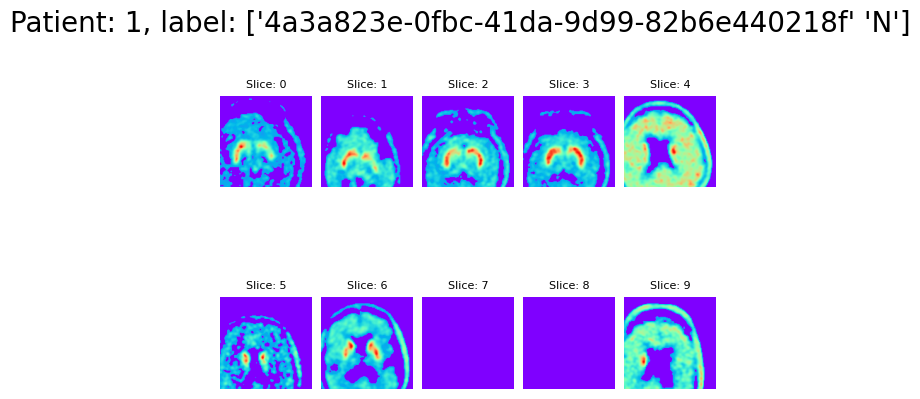

In [13]:
plot_slices(X_DATA, Y_D)

In [14]:
X_DATA_NEW, Y_DATA_NEW = prep_dataset(X_DATA_NEW, Y_DATA_NEW, num_classes=num_classes)

In [15]:
X_DATA_TRAIN, X_DATA_VAL, Y_DATA_TRAIN, Y_DATA_VAL = train_test_split(X_DATA_NEW, Y_DATA_NEW, test_size=0.20, random_state=random_state)

In [ ]:
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)

model = build_model(img_size=img_size, num_classes=num_classes)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.Recall()]
)

callbacks = [
    keras.callbacks.EarlyStopping(
        patience=10,
        monitor='val_loss'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_filepath,
        save_best_only=True
    )
]

history = model.fit(
    x = X_DATA_TRAIN,
    y = Y_DATA_TRAIN,
    batch_size=batch_size,
    validation_data=(X_DATA_VAL, Y_DATA_VAL),
    epochs=epochs,
    callbacks=callbacks,
    shuffle=True,
)


hist_df = pd.DataFrame(history.history)
with open(hist_csv_filepath, mode='w') as f:
    hist_df.to_csv(f)

with open(summary_filepath, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))


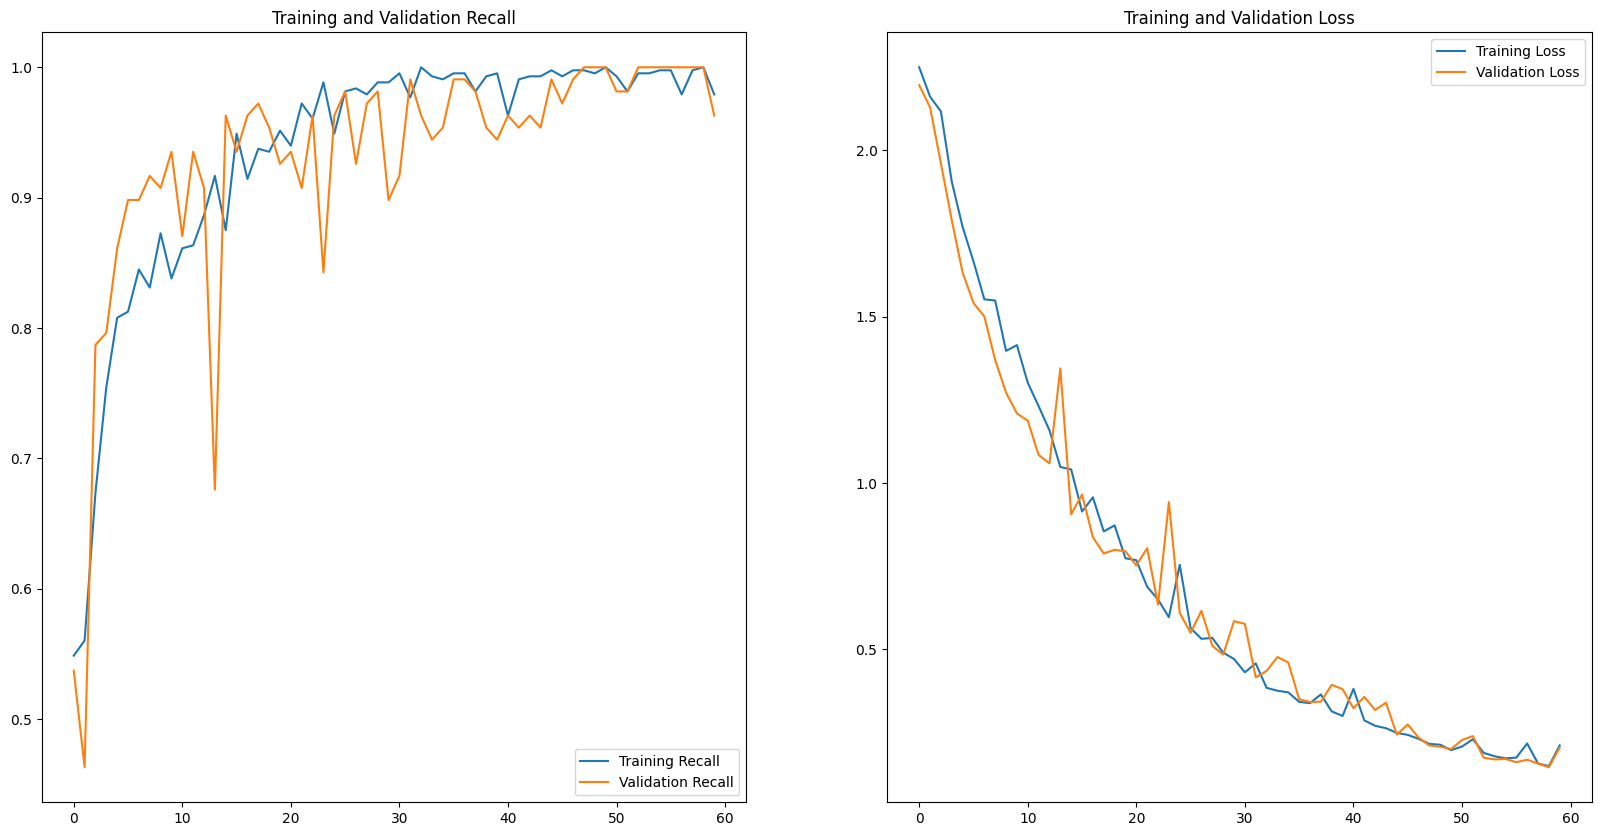

In [25]:
rec = history.history['recall']
val_rec = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_loss_metric(loss, val_loss, rec, val_rec, metric_name='recall')

In [18]:
X_DATA_TEST, Y_DATA_TEST = prep_dataset(X_DATA_TEST, Y_DATA_TEST, num_classes)

In [19]:
model = keras.models.load_model(model_filepath)
results = model.evaluate(X_DATA_TEST, Y_DATA_TEST)

1/1 [==============================] - 0s 282ms/step - loss: 1.5898 - recall: 0.8519


In [20]:
predictions = model.predict(X_DATA_TEST)

1/1 [==============================] - 0s 89ms/step


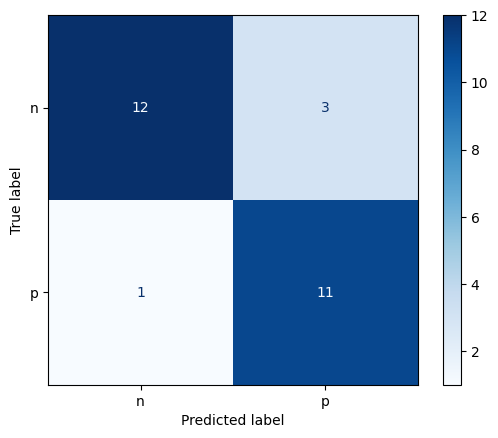

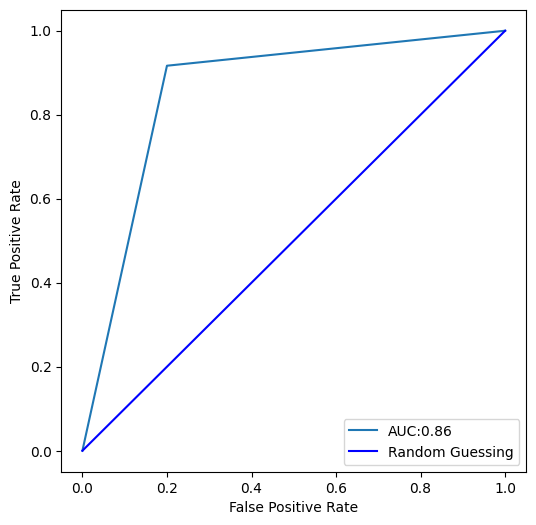

ROC AUC score: 0.8583333333333333


In [59]:
targets = ['n', 'p']
ConfusionMatrixDisplay.from_predictions(np.argmax(Y_DATA_TEST, axis=1),
                                        np.argmax(predictions, axis=1),
                                        display_labels=targets,
                                        cmap='Blues')

print('ROC AUC score:', multiclass_roc_auc_score(np.argmax(Y_DATA_TEST, axis=1),
                                                 np.argmax(predictions, axis=1),
                                                 target_list=targets,
                                                 multiclass=False))

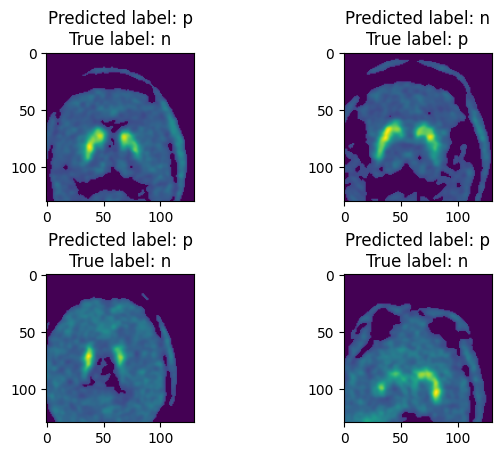

In [109]:
targets_dict = {
    '0': 'n',
    '1': 'p'
}

display_errors(targets_dict, X_DATA_TEST[:,:,:,3], Y_DATA_TEST, predictions)